# Bone Age Assessment using CNN + Grad-CAM

This notebook demonstrates the application of **Grad-CAM (Gradient-weighted Class Activation Mapping)** to visualize which regions of pediatric hand X-ray images influence the prediction of a **CNN-based bone age regression model**.

A previously trained **ResNet-50–based regression model** is loaded using saved `.pth` weights, and Grad-CAM is applied to interpret the model’s predictions.

---

###  Objectives
- Load a trained CNN bone-age regressor
- Apply Grad-CAM for model interpretability
- Visualize attention regions on hand X-ray images
- Overlay heatmaps on original images for analysis

---

### Dataset Used
- **Training Dataset:** Bone Age Training X-rays  
- **Test Dataset:** Bone Age Test X-rays  

### Model
- Backbone: **ResNet-50**
- Input: Grayscale X-ray image + sex encoding
- Output: Bone age prediction (in years)

---


## 1 Imports and Basic Configuration

In this section, we:
- Import all required Python libraries
- Set device configuration (CPU / GPU)
- Define file paths for datasets and trained model weights
- Declare image normalization parameters used during training


In [34]:
# =========================
# 1. IMPORTS & CONFIG
# =========================

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torchvision import models, transforms

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- PATHS (CHANGE THESE IF NEEDED) ---

BEST_MODEL_PATH = r"C:\Users\whois\OneDrive\Desktop\sem 5\pr ml-elective\PR\trained_model_weights\best_cnn_regressor_final (1).pth"

TRAIN_IMG_DIR = r"C:\Users\whois\OneDrive\Desktop\sem 5\pr ml-elective\PR\boneage-training-dataset"
TEST_IMG_DIR  = r"C:\Users\whois\OneDrive\Desktop\sem 5\pr ml-elective\PR\boneage-test-dataset\boneage-test-dataset"

# Image size & normalization (same as training)
IMG_SIZE = 256
MEAN_GREY = [0.5]
STD_GREY = [0.5]


Using device: cpu


## 2 Model Architecture and Weight Loading

Here, we reconstruct the CNN-based bone age regression model **exactly as used during training**, including:

- A **ResNet-50 backbone**
- Support for **1-channel grayscale** X-ray images
- Concatenation of **sex encoding** as an auxiliary input
- A fully connected regression head

After defining the architecture, we load the **best-performing trained weights** from a `.pth` file and set the model to evaluation mode.


In [35]:
# =========================
# 2. MODEL ARCHITECTURE
# =========================

class BoneAgeCNN(nn.Module):
    """ResNet-50-based bone age regressor for 1-channel images + 1 sex feature."""
    def __init__(self):
        super(BoneAgeCNN, self).__init__()

        # 1. Base ResNet-50 (no pretrained weights)
        self.resnet = models.resnet50(weights=None)

        # 2. Adapt first conv layer to 1-channel input
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=False
        )

        # Initialize conv1 weights by averaging the original RGB weights
        with torch.no_grad():
            self.resnet.conv1.weight = nn.Parameter(
                original_conv1.weight.mean(dim=1, keepdim=True)
            )

        # 3. Feature extractor up to avgpool
        self.features = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,
            self.resnet.avgpool,
            nn.Flatten()
        )

        # 4. Regression head: 2048 CNN features + 1 sex feature
        self.regression_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048 + 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, image, sex_encoded):
        # image: [B, 1, H, W], sex_encoded: [B, 1] or [B]
        cnn_features = self.features(image)               # [B, 2048]
        sex_encoded = sex_encoded.view(-1, 1)             # [B, 1]
        combined = torch.cat((cnn_features, sex_encoded), dim=1)
        prediction = self.regression_head(combined)       # [B, 1]

        # Clip to realistic age range (0–19 years)
        prediction = torch.clamp(prediction, min=0.0, max=19.0)
        return prediction


# =========================
# 2b. LOAD TRAINED WEIGHTS
# =========================

model = BoneAgeCNN().to(device)

print("Loading weights from:", BEST_MODEL_PATH)
state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("✅ Model loaded and set to eval mode.")


Loading weights from: C:\Users\whois\OneDrive\Desktop\sem 5\pr ml-elective\PR\trained_model_weights\best_cnn_regressor_final (1).pth
✅ Model loaded and set to eval mode.


## 3 Image Preprocessing and Loader

This section defines:
- Image preprocessing transformations (resize, grayscale, normalization)
- A helper function to load a single X-ray image
- Conversion of the image into a tensor suitable for the CNN

These steps ensure consistency between training and inference pipelines.


In [36]:
# =========================
# 3. TRANSFORMS & IMAGE LOADER
# =========================

val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_GREY, std=STD_GREY)
])

def load_image_tensor(img_path):
    """Load a single PNG image and convert it to a [1, 1, H, W] tensor on device."""
    img = Image.open(img_path).convert("L")  # grayscale
    img_t = val_test_transforms(img)        # [1, H, W]
    img_t = img_t.unsqueeze(0)              # [1, 1, H, W]
    return img, img_t.to(device)


## 4 Grad-CAM (Gradient-weighted Class Activation Mapping)

Grad-CAM is a visualization technique that highlights regions of an image that contribute most to a model’s output.

In this section:
- Hooks are registered on the **final convolutional layer** of the ResNet-50
- Gradients and feature maps are captured during backpropagation
- Importance weights are computed and combined into a heatmap
- The heatmap is resized and normalized for visualization

This allows us to interpret **what the model focuses on** while predicting bone age.


In [37]:
# =========================
# 4. GRAD-CAM CLASS
# =========================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            # Save feature maps
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple; we care about grad wrt output feature maps
            self.gradients = grad_out[0].detach()

        self.fwd_handle = self.target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, image_tensor, sex_tensor):
        """
        image_tensor: [1, 1, H, W]
        sex_tensor: [1] or [1, 1]
        returns: cam (H, W) numpy array in [0, 1], predicted age (float)
        """
        self.model.zero_grad()
        self.gradients = None
        self.activations = None

        # Forward pass
        output = self.model(image_tensor, sex_tensor)  # [1, 1]
        # For regression, we just backprop the scalar
        target = output[0, 0]
        target.backward()

        # Get stored values
        grads = self.gradients          # [1, C, H', W']
        acts = self.activations         # [1, C, H', W']

        # Global average pooling over spatial dims -> weights
        weights = grads.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]

        # Weighted sum of activations
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [1, 1, H', W']
        cam = torch.relu(cam)

        # Upsample to input size
        cam = torch.nn.functional.interpolate(
            cam,
            size=(image_tensor.size(2), image_tensor.size(3)),
            mode="bilinear",
            align_corners=False
        )

        cam = cam.squeeze().cpu().numpy()
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)   # normalize to [0, 1]

        pred_age = float(output.detach().cpu().numpy().squeeze())
        return cam, pred_age

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()


# Instantiate Grad-CAM with last conv block
gradcam = GradCAM(model, model.resnet.layer4)
print("Grad-CAM ready.")


Grad-CAM ready.


## 5️ Grad-CAM on a Sample X-ray Image

In this section, we:
- Select a single X-ray image from the test dataset
- Specify the corresponding **sex encoding** (0 = female, 1 = male)
- Perform a forward and backward pass through the model
- Generate the Grad-CAM heatmap
- Overlay the heatmap on the original image

This visualization helps understand which anatomical regions influence the predicted bone age.


Using image: C:\Users\whois\OneDrive\Desktop\sem 5\pr ml-elective\PR\boneage-test-dataset\boneage-test-dataset\4361.png
Predicted age: 13.56 years


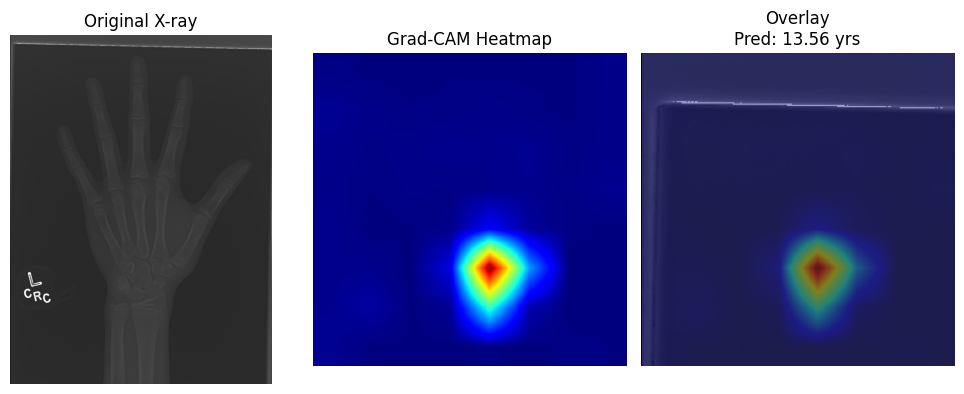

In [38]:
# =========================
# 5. RUN GRAD-CAM ON SAMPLE
# =========================

# Example: pick any .png in your test folder
example_image_path = os.path.join(TEST_IMG_DIR, "4361.png")  # <-- CHANGE THIS

if not os.path.exists(example_image_path):
    # fallback: just grab the first PNG in the folder
    all_imgs = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(".png")]
    if len(all_imgs) == 0:
        raise FileNotFoundError("No .png images found in TEST_IMG_DIR.")
    example_image_path = os.path.join(TEST_IMG_DIR, all_imgs[0])

print("Using image:", example_image_path)

# Set sex encoding for this example
# CHANGE this depending on the image:
# 1.0 = male, 0.0 = female (assuming same as training)
sex_encoded_value = 1.0   # <-- CHANGE IF NEEDED

sex_tensor = torch.tensor([sex_encoded_value], dtype=torch.float32, device=device)

# Load image & get Grad-CAM
orig_img, img_tensor = load_image_tensor(example_image_path)
cam, pred_age = gradcam(img_tensor, sex_tensor)

print(f"Predicted age: {pred_age:.2f} years")

# =========================
# 5b. VISUALIZE
# =========================

plt.figure(figsize=(10,4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(orig_img, cmap="gray")
plt.title("Original X-ray")
plt.axis("off")

# Heatmap only
plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(orig_img, cmap="gray")
plt.imshow(cam, cmap="jet", alpha=0.4)
plt.title(f"Overlay\nPred: {pred_age:.2f} yrs")
plt.axis("off")

plt.tight_layout()
plt.show()


## 6️ Visualization of Results

We visualize:
- The **original hand X-ray image**
- The **Grad-CAM heatmap**
- An **overlay** of the heatmap on the original image

Hotter regions (red/yellow) indicate higher influence on the model’s prediction, providing interpretability for clinical and academic analysis.


##  Conclusion

This notebook demonstrates how **Grad-CAM** can be used to interpret a deep learning model for **bone age assessment**.

Key takeaways:
- Grad-CAM provides visual explanations for CNN predictions
- The model focuses on biologically relevant regions of the hand
- Such interpretability improves trust and usefulness in medical AI systems

This approach bridges the gap between **high model accuracy** and **human-understandable reasoning**, which is essential in healthcare applications.
